In [64]:
import os
import requests
import json
import pandas as pd
#import yfinance as yf
#import pendulum
import matplotlib.pyplot as plt
from MCForecastTools import MCSimulation

from dotenv import load_dotenv
import alpaca_trade_api as tradeapi


%matplotlib inline

In [65]:
load_dotenv('keys.env')

True

In [66]:
import numpy as np
#from pandas_datareader import data as wb
import seaborn as sns
from scipy.stats import norm
import datetime as dt

import pytz

In [70]:
#political_portfolio_dict_stock_list = [{'Mark_Warner': ['SPY', 'AKREX', 'TROW', 'COHOX', 'VTI']}, 
 #{'Greg_Gianforte': ['QQQ', 'SPY', 'VTI', 'FICO', 'WK', 'CRM']},
 #{'Nancy_Pelosi': ['AAPL', 'V', 'DIS', 'CRM', 'META', 'CMCSA']}]
                 
#Mark Warner: SPDR s&p 500 etf, Akre focus fund, t. rowe price group, coho relative value equity fund, vanguard 

#Greg Gianforte: invesco qqq, SPDr s&p 500, vanguard, FICO, Workiva, salesforce

#Nancy Pelosi: apple, visa, disney, salesforce, facebook, comcast

In [71]:
warner_weights=[0.24, 0.23, 0.22, 0.22, 0.09]
warner_investment_capital=116000000.00

#Warner range of investments from $80m to $348m. Maximum value of assets assumed in calculations.
#investment capital reduced by 2/3 to allow for easier analysis and accomodate top 1/3 of stock 
#investment portfolio. Net worth assumed as investment capital. AMG GW&K Municipal bond fund removed from 
#top 1/3 of stock assets to simplify calculations.

gianforte_weights=[0.26, 0.22, 0.35, 0.08, 0.05, 0.04]
gianforte_investment_capital = 94500000.00

#weights of stocks making up 1/2 of Gianforte investment portfolio. Different Vanguard funds summed. 
#investment capital reduced by 1/2 to allow for easier analysis and accomodate top
#1/2 of stock investment portfolio. Net worth assumed as investment capital. 

pelosi_weights=[0.40, 0.40, 0.08, 0.08, 0.02, 0.02]
pelosi_investment_capital= 64000000.00
                
#Pelosi range of investments from $54m to $256m. Max value investments/assets assumed in calculations. 
#investment capital reduced by 3/4 to allow for easier analysis and accomodate top
#1/4 of stock investment portfolio. Net worth assumed as investment capital.

In [72]:
warner_tickers= ['SPY', 'AKREX', 'TROW', 'COHOX', 'VTI']
gianforte_tickers=['QQQ', 'SPY', 'VTI', 'FICO', 'WK', 'CRM']
pelosi_tickers=['AAPL', 'V', 'DIS', 'CRM', 'META', 'CMCSA']

#timeframe='1Day'

#start_date = pd.Timestamp("2020-08-07", tz="America/New_York").isoformat()
#end_date = pd.Timestamp("2020-08-07", tz="America/New_York").isoformat()

In [73]:
#warner_stock_info=yf.Tickers(warner_tickers)
#warner_df=warner_stock_info.history(period='5y')
#warner_df=pd.DataFrame(warner_df)
#warner_df.columns = pd.MultiIndex.from_product([warner_df.columns, ['Close']])
#warner_close_data=warner_df['Close']
#warner_close_data=warner_close_data.reindex(columns=warner_tickers)
#display(warner_close_data)

In [118]:
start_date = pd.Timestamp("2018-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-05-01", tz="America/New_York").isoformat()
timeframe="1Day"
load_dotenv('keys.env')

# Set Alpaca API key and secret key
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)
print(warner_tickers)
warner_prices_df = alpaca.get_bars(warner_tickers,timeframe,start_date,end_date).df
#warner_stock_info=yf.Tickers(warner_tickers)
#warner_df=warner_stock_info.history(period='5y')
#warner_df=pd.DataFrame(warner_df)
#warner_close_data=warner_df['Close']
#warner_close_data=warner_close_data.reindex(columns=warner_tickers)  
spy_df = warner_prices_df[warner_prices_df['symbol']=='SPY'].drop('symbol',axis=1)
akrex_df = warner_prices_df[warner_prices_df['symbol']=='SPY'].drop('symbol',axis=1)
trow_df = warner_prices_df[warner_prices_df['symbol']=='SPY'].drop('symbol',axis=1)
cohox_df = warner_prices_df[warner_prices_df['symbol']=='SPY'].drop('symbol',axis=1)
vti_df = warner_prices_df[warner_prices_df['symbol']=='SPY'].drop('symbol',axis=1)
warner_prices_df = pd.concat([spy_df, akrex_df, trow_df, cohox_df, vti_df],axis=1,keys=['SPY', 'AKREX', 'TROW', 'COHOX', 'VTI'])
#display(warner_prices_df)
#warner_returns=warner_close_data.pct_change()
#mean_warner_returns=warner_returns.mean()
#std_warner_returns=warner_returns.std()
##################################################below copied from MCForecastTools.py


# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import alpaca_trade_api as tradeapi
import datetime as dt
import pytz

class MCSimulation:
    """
    A Python class for runnning Monte Carlo simulation on portfolio price data. 
    
    ...
    
    Attributes
    ----------
    portfolio_data : pandas.DataFrame
        portfolio dataframe
    weights: list(float)
        portfolio investment breakdown
    nSim: int
        number of samples in simulation
    nTrading: int
        number of trading days to simulate
    simulated_return : pandas.DataFrame
        Simulated data from Monte Carlo
    confidence_interval : pandas.Series
        the 95% confidence intervals for simulated final cumulative returns
        
    """
    
    def __init__(self, portfolio_data, weights="", num_simulation=1000, num_trading_days=252):
        """
        Constructs all the necessary attributes for the MCSimulation object.

        Parameters
        ----------
        portfolio_data: pandas.DataFrame
            DataFrame containing stock price information from Alpaca API
        weights: list(float)
            A list fractions representing percentage of total investment per stock. DEFAULT: Equal distribution
        num_simulation: int
            Number of simulation samples. DEFAULT: 1000 simulation samples
        num_trading_days: int
            Number of trading days to simulate. DEFAULT: 252 days (1 year of business days)
        """
        
        # Check to make sure that all attributes are set
        if not isinstance(portfolio_data, pd.DataFrame):
            raise TypeError("portfolio_data must be a Pandas DataFrame")
            
        # Set weights if empty, otherwise make sure sum of weights equals one.
        if weights == "":
            num_stocks = len(portfolio_data.columns.get_level_values(0).unique())
            weights = [1.0/num_stocks for s in range(0,num_stocks)]
        else:
            if round(sum(weights),2) < .99:
                raise AttributeError("Sum of portfolio weights must equal one.")
        
        # Calculate daily return if not within dataframe
        if not "daily_return" in portfolio_data.columns.get_level_values(1).unique():
            close_df = portfolio_data.xs('close',level=1,axis=1).pct_change()
            tickers = portfolio_data.columns.get_level_values(0).unique()
            column_names = [(x,"daily_return") for x in tickers]
            close_df.columns = pd.MultiIndex.from_tuples(column_names)
            portfolio_data = portfolio_data.merge(close_df,left_index=True,right_index=True).reindex(columns=tickers,level=0)    
        
        # Set class attributes
        self.portfolio_data = portfolio_data
        self.weights = weights
        self.nSim = num_simulation
        self.nTrading = num_trading_days
        self.simulated_return = ""
        
    def calc_cumulative_return(self):
        """
        Calculates the cumulative return of a stock over time using a Monte Carlo simulation (Brownian motion with drift).

        """
        
        # Get closing prices of each stock
        last_prices = self.portfolio_data.xs('close',level=1,axis=1)[-1:].values.tolist()[0]
        
        # Calculate the mean and standard deviation of daily returns for each stock
        daily_returns = self.portfolio_data.xs('daily_return',level=1,axis=1)
        mean_returns = daily_returns.mean().tolist()
        std_returns = daily_returns.std().tolist()
        
        # Initialize empty Dataframe to hold simulated prices
        portfolio_cumulative_returns = pd.DataFrame()
        
        # Run the simulation of projecting stock prices 'nSim' number of times
        for n in range(self.nSim):
        
            if n % 10 == 0:
                print(f"Running Monte Carlo simulation number {n}.")
        
            # Create a list of lists to contain the simulated values for each stock
            simvals = [[p] for p in last_prices]
    
            # For each stock in our data:
            for s in range(len(last_prices)):

                # Simulate the returns for each trading day
                for i in range(self.nTrading):
        
                    # Calculate the simulated price using the last price within the list
                    simvals[s].append(simvals[s][-1] * (1 + np.random.normal(mean_returns[s], std_returns[s])))
    
            # Calculate the daily returns of simulated prices
            sim_df = pd.DataFrame(simvals).T.pct_change()
    
            # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
            sim_df = sim_df.dot(self.weights)
    
            # Calculate the normalized, cumulative return series
            portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
        
        # Set attribute to use in plotting
        self.simulated_return = portfolio_cumulative_returns
        
        # Calculate 95% confidence intervals for final cumulative returns
        self.confidence_interval = portfolio_cumulative_returns.iloc[-1, :].quantile(q=[0.025, 0.975])
        
        return portfolio_cumulative_returns
    
    def plot_simulation(self):
        """
        Visualizes the simulated stock trajectories using calc_cumulative_return method.

        """ 
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
            
        # Use Pandas plot function to plot the return data
        plot_title = f"{self.nSim} Simulations of Cumulative Portfolio Return Trajectories Over the Next {self.nTrading} Trading Days."
        return self.simulated_return.plot(legend=None,title=plot_title)
    
    def plot_distribution(self):
        """
        Visualizes the distribution of cumulative returns simulated using calc_cumulative_return method.

        """
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
        
        # Use the `plot` function to create a probability distribution histogram of simulated ending prices
        # with markings for a 95% confidence interval
        plot_title = f"Distribution of Final Cumuluative Returns Across All {self.nSim} Simulations"
        plt = self.simulated_return.iloc[-1, :].plot(kind='hist', bins=10,density=True,title=plot_title)
        plt.axvline(self.confidence_interval.iloc[0], color='r')
        plt.axvline(self.confidence_interval.iloc[1], color='r')
        return plt
    
    def summarize_cumulative_return(self):
        """
        Calculate final summary statistics for Monte Carlo simulated stock data.
        
        """
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
            
        metrics = self.simulated_return.iloc[-1].describe()
        ci_series = self.confidence_interval
        ci_series.index = ["95% CI Lower","95% CI Upper"]
        return metrics.append(ci_series)
warner_MC_10yr = MCSimulation(
    portfolio_data = warner_prices_df,
    weights = warner_weights,
    num_simulation = 500,
    num_trading_days = 252*10
)


# Review the simulation input data
warner_MC_10yr.portfolio_data.head()

['SPY', 'AKREX', 'TROW', 'COHOX', 'VTI']


SPY                                       \
                             open      high     low   close     volume   
timestamp                                                                
2018-05-01 04:00:00+00:00  263.87  265.1000  262.11  264.96   76110600   
2018-05-02 04:00:00+00:00  264.76  265.6800  262.76  263.17   86373743   
2018-05-03 04:00:00+00:00  262.26  263.3600  259.05  262.59  136921861   
2018-05-04 04:00:00+00:00  261.52  266.7892  261.15  265.92   91230645   
2018-05-07 04:00:00+00:00  266.89  268.0200  266.11  266.92   56495099   

                                                                 AKREX  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2018-05-01 04:00:00+00:00      296318  263.924372          NaN  263.87   
2018-05-02 04:00:00+00:00      300565  264.118423    -0.006756  264.76   
2018-05-03 04:00:00+00:00      519981  261.686187    -0.002204  262.26   
2018-05-04 04:00:00+00:00      326945  264.854905     0.012681  261.52   
2018-05-07 04:00:00+00:00      242699  267.100589     0.003761  266.89   

                                     ...       COHOX                  VTI  \
                               high  ...        vwap daily_return    open   
timestamp                            ...                                    
2018-05-01 04:00:00+00:00  265.1000  ...  263.924372          NaN  263.87   
2018-05-02 04:00:00+00:00  265.6800  ...  264.118423    -0.006756  264.76   
2018-05-03 04:00:00+00:00  263.3600  ...  261.686187    -0.002204  262.26   
2018-05-04 04:00:00+00:00  266.7892  ...  264.854905     0.012681  261.52   
2018-05-07 04:00:00+00:00  268.0200  ...  267.100589     0.003761  266.89   

                                                                            \
                               high     low   close     volume trade_count   
timestamp                                                                    
2018-05-01 04:00:00+00:00  265.1000  262.11  264.96   76110600      296318   
2018-05-02 04:00:00+00:00  265.6800  262.76  263.17   86373743      300565   
2018-05-03 04:00:00+00:00  263.3600  259.05  262.59  136921861      519981   
2018-05-04 04:00:00+00:00  266.7892  261.15  265.92   91230645      326945   
2018-05-07 04:00:00+00:00  268.0200  266.11  266.92   56495099      242699   

                                                    
                                 vwap daily_return  
timestamp                                           
2018-05-01 04:00:00+00:00  263.924372          NaN  
2018-05-02 04:00:00+00:00  264.118423    -0.006756  
2018-05-03 04:00:00+00:00  261.686187    -0.002204  
2018-05-04 04:00:00+00:00  264.854905     0.012681  
2018-05-07 04:00:00+00:00  267.100589     0.003761  

[5 rows x 40 columns]

In [119]:
warner_MC_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Owner\anaconda3\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.990660,1.003152,1.014161,0.998486,1.002172,0.998390,0.988717,0.996387,0.997560,1.005875,...,1.005634,0.998368,0.999748,0.997673,0.996543,1.006634,0.998470,1.004268,0.995369,0.991065
2,0.993351,0.999148,1.007834,0.996161,1.009456,1.006916,0.985088,0.997649,0.984345,1.003659,...,1.023002,1.007627,0.985493,0.989040,0.999161,0.998748,0.998747,0.996466,0.997877,0.988757
3,0.987493,0.999134,1.006512,0.999934,0.997252,1.004933,0.986028,0.994945,0.984430,1.014627,...,1.033692,1.005426,0.972604,0.991322,0.989683,0.988280,0.993640,0.999596,1.004163,0.992514
4,0.990045,1.011725,1.016156,1.004293,0.987503,0.996962,0.983641,0.988950,0.980971,1.011193,...,1.031548,1.013762,0.965727,0.983793,0.984359,0.980828,0.995194,1.004760,0.996925,0.991116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.856857,2.124335,2.804238,2.119370,1.338793,1.512509,1.578392,1.291623,1.015624,2.347269,...,1.627933,3.653250,1.556086,1.951493,2.559408,3.206958,2.314497,2.247054,1.661350,1.737186
2517,2.822676,2.125856,2.816357,2.122150,1.343136,1.509612,1.571942,1.285774,1.009111,2.352013,...,1.605835,3.700033,1.567384,1.932676,2.563010,3.217173,2.320989,2.250950,1.670623,1.730677
2518,2.827796,2.117478,2.820321,2.140467,1.357370,1.496168,1.568291,1.294072,1.018038,2.375077,...,1.614550,3.685441,1.538629,1.926948,2.562145,3.237522,2.329533,2.227371,1.693234,1.724416
2519,2.870851,2.109254,2.779571,2.155636,1.359801,1.504549,1.564036,1.301510,1.021204,2.411478,...,1.612600,3.705371,1.542931,1.932733,2.540295,3.217614,2.335779,2.243850,1.707188,1.713694


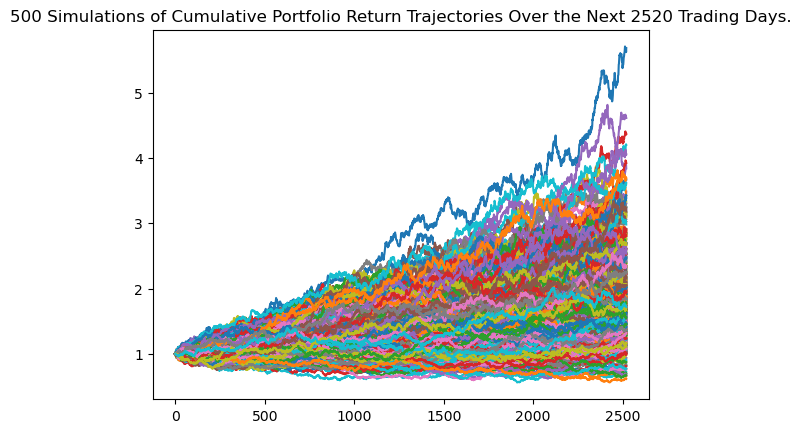

In [120]:
warner_MC_sim_line_plot = warner_MC_10yr.plot_simulation()

In [151]:
warner_MC_summary_stats = warner_MC_10yr.summarize_cumulative_return()
print(warner_MC_summary_stats)

count           500.000000
mean              1.829731
std               0.659178
min               0.615786
25%               1.388634
50%               1.748923
75%               2.119746
max               5.682898
95% CI Lower      0.830714
95% CI Upper      3.403397
Name: 2520, dtype: float64


In [152]:
ci_lower_10_cumulative_return_warner = warner_MC_summary_stats[8]*warner_investment_capital
ci_upper_10_cumulative_return_warner = warner_MC_summary_stats[9]*warner_investment_capital

print(f"there is a 95% chance that over the next 10 years the Warner stock portfolio will end with a range between ${ci_lower_10_cumulative_return_warner: .2f} and ${ci_upper_10_cumulative_return_warner: .2f}")

there is a 95% chance that over the next 10 years the Warner stock portfolio will end with a range between $ 96362803.22 and $ 394794051.41


In [122]:
warner_stock_info=yf.Tickers(warner_tickers)
warner_df=warner_stock_info.history(period='5y')
warner_df=pd.DataFrame(warner_df)
warner_close_data=warner_df['Close']
warner_close_data=warner_close_data.reindex(columns=warner_tickers)
display(warner_close_data)

[*********************100%***********************]  5 of 5 completed


,SPY,AKREX,TROW,COHOX,VTI
Date,,,,,
2018-01-29 00:00:00-05:00,261.374146,30.276783,100.001556,11.290659,134.025452
2018-01-30 00:00:00-05:00,258.693207,30.154554,95.713966,11.117401,132.629181
2018-01-31 00:00:00-05:00,258.821686,30.320431,94.965324,11.030772,132.675125
2018-02-01 00:00:00-05:00,258.527954,30.451389,95.416229,11.001896,132.619965
2018-02-02 00:00:00-05:00,252.899796,29.814074,93.485085,10.770885,129.799850
...,...,...,...,...,...
2023-01-23 00:00:00-05:00,400.630005,49.730000,118.669998,15.780000,201.279999
2023-01-24 00:00:00-05:00,400.200012,49.599998,117.480003,15.760000,200.949997
2023-01-25 00:00:00-05:00,400.350006,49.619999,116.639999,15.840000,201.050003


In [141]:
warner_returns=warner_close_data.pct_change()
mean_warner_returns=warner_returns.mean()
std_warner_returns=warner_returns.std()


In [142]:
MC_30yr = MCSimulation(
    portfolio_data = warner_close_data,
    weights = warner_weights,
    num_simulation = 500,
    num_trading_days = 252*30
)

# Review the simulation input data
MC_30yr.portfolio_data.head()

IndexError: Too many levels: Index has only 1 level, not 2

In [146]:
gianforte_stock_info=yf.Tickers(gianforte_tickers)
gianforte_df=gianforte_stock_info.history(period='5y')
gianforte_df=pd.DataFrame(gianforte_df)
gianforte_close_data=gianforte_df['Close']
gianforte_close_data=gianforte_close_data.reindex(columns= gianforte_tickers)
display(gianforte_close_data)

[*********************100%***********************]  6 of 6 completed


,QQQ,SPY,VTI,FICO,WK,CRM
Date,,,,,,
2018-01-29 00:00:00-05:00,164.340347,261.374176,134.025482,176.130005,22.200001,113.300003
2018-01-30 00:00:00-05:00,162.987762,258.693237,132.629181,173.520004,22.049999,112.230003
2018-01-31 00:00:00-05:00,163.664062,258.821716,132.675110,172.660004,22.299999,113.910004
2018-02-01 00:00:00-05:00,162.272827,258.527893,132.619965,172.839996,22.250000,112.739998
2018-02-02 00:00:00-05:00,159.036255,252.899765,129.799850,169.380005,22.299999,110.779999
...,...,...,...,...,...,...
2023-01-23 00:00:00-05:00,288.959991,400.630005,201.279999,649.950012,92.570000,155.869995
2023-01-24 00:00:00-05:00,288.369995,400.200012,200.949997,640.219971,90.459999,154.860001
2023-01-25 00:00:00-05:00,287.730011,400.350006,201.050003,642.830017,90.580002,156.169998


In [118]:
gianforte_returns=gianforte_close_data.pct_change()
mean_gianforte_returns=gianforte_returns.mean()
std_gianforte_returns=gianforte_returns.std()

In [147]:
pelosi_stock_info=yf.Tickers(pelosi_tickers)
pelosi_df=pelosi_stock_info.history(period='5y')
pelosi_df=pd.DataFrame(pelosi_df)
pelosi_close_data=pelosi_df['Close']
pelosi_close_data=pelosi_close_data.reindex(columns= pelosi_tickers)
display(pelosi_close_data)

[*********************100%***********************]  6 of 6 completed


,AAPL,V,DIS,CRM,META,CMCSA
Date,,,,,,
2018-01-29 00:00:00-05:00,39.928276,120.807625,108.473206,113.300003,185.979996,37.564678
2018-01-30 00:00:00-05:00,39.692932,119.559319,107.082520,112.230003,187.119995,37.886818
2018-01-31 00:00:00-05:00,39.802284,120.217331,105.682114,113.910004,186.889999,38.056847
2018-02-01 00:00:00-05:00,39.885483,121.659203,107.452065,112.739998,193.089996,37.484154
2018-02-02 00:00:00-05:00,38.154850,117.004578,105.711281,110.779999,190.279999,36.786190
...,...,...,...,...,...,...
2023-01-23 00:00:00-05:00,141.110001,224.179993,105.690002,155.869995,143.270004,40.259998
2023-01-24 00:00:00-05:00,142.529999,223.889999,106.000000,154.860001,143.139999,39.750000
2023-01-25 00:00:00-05:00,141.860001,224.899994,108.120003,156.169998,141.500000,40.099998


In [119]:
pelosi_returns=pelosi_close_data.pct_change()
mean_pelosi_returns=pelosi_returns.mean()
std_pelosi_returns=pelosi_returns.std()

In [ ]:
#warner_returns=warner_close_data.pct_change()
#warner_returns.head()
#mean_warner_returns=warner_returns.mean()
#std_warner_returns=warner_returns.std()

#display(warner_returns.dropna())

In [ ]:
#warner_portfolio_returns=warner_returns.dot(warner_weights)
#warner_portfolio_returns.head()

In [ ]:
#warner_variance=warner_returns.cov()*252
#warner_variance

In [ ]:
#warner_portfolio_variance=np.transpose(warner_weights)@warner_variance@warner_weights
#warner_portfolio_volitility=np.sqrt(warner_portfolio_variance)
#display(f"warner_portfolio_variance is", warner_portfolio_variance)
#display(f"warner_portfolio_volitility is", warner_portfolio_volitility)

In [ ]:
#gianforte_stock_info=yf.Tickers(gianforte_tickers)
#gianforte_df=gianforte_stock_info.history(period='5y')
#gianforte_df=pd.DataFrame(gianforte_df)
#gianforte_close_data=gianforte_df['Close']
#gianforte_close_data=gianforte_close_data.reindex(columns= gianforte_tickers)
#display(gianforte_close_data)

In [91]:
print(gianforte_tickers)
gianforte_prices_df = alpaca.get_bars(gianforte_tickers,timeframe,start_date,end_date).df

['QQQ', 'SPY', 'VTI', 'FICO', 'WK', 'CRM']


In [145]:
print(gianforte_tickers)
gianforte_prices_df = alpaca.get_bars(gianforte_tickers,timeframe,start_date,end_date).df
#warner_stock_info=yf.Tickers(warner_tickers)
#warner_df=warner_stock_info.history(period='5y')
#warner_df=pd.DataFrame(warner_df)
#warner_close_data=warner_df['Close']
#warner_close_data=warner_close_data.reindex(columns=warner_tickers)  
qqq_df = gianforte_prices_df[gianforte_prices_df['symbol']=='QQQ'].drop('symbol',axis=1)
spy_df = gianforte_prices_df[gianforte_prices_df['symbol']=='QQQ'].drop('symbol',axis=1)
vti_df = gianforte_prices_df[gianforte_prices_df['symbol']=='QQQ'].drop('symbol',axis=1)
fico_df =gianforte_prices_df[gianforte_prices_df['symbol']=='QQQ'].drop('symbol',axis=1)
wk_df = gianforte_prices_df[gianforte_prices_df['symbol']=='QQQ'].drop('symbol',axis=1)
crm_df = gianforte_prices_df[gianforte_prices_df['symbol']=='QQQ'].drop('symbol',axis=1)
gianforte_prices_df = pd.concat([qqq_df,spy_df,vti_df,fico_df,wk_df,crm_df],axis=1,keys=['QQQ', 'SPY', 'VTI', 'FICO', 'WK', 'CRM'])


#warner_returns=warner_close_data.pct_change()
#mean_warner_returns=warner_returns.mean()
#std_warner_returns=warner_returns.std()
gianforte_MC_10yr = MCSimulation(
    portfolio_data = gianforte_prices_df,
    weights = gianforte_weights,
    num_simulation = 500,
    num_trading_days = 252*10
)


class MCSimulation:
    """
    A Python class for runnning Monte Carlo simulation on portfolio price data. 
    
    ...
    
    Attributes
    ----------
    portfolio_data : pandas.DataFrame
        portfolio dataframe
    weights: list(float)
        portfolio investment breakdown
    nSim: int
        number of samples in simulation
    nTrading: int
        number of trading days to simulate
    simulated_return : pandas.DataFrame
        Simulated data from Monte Carlo
    confidence_interval : pandas.Series
        the 95% confidence intervals for simulated final cumulative returns
        
    """
    
    def __init__(self, portfolio_data, weights="", num_simulation=1000, num_trading_days=252):
        """
        Constructs all the necessary attributes for the MCSimulation object.

        Parameters
        ----------
        portfolio_data: pandas.DataFrame
            DataFrame containing stock price information from Alpaca API
        weights: list(float)
            A list fractions representing percentage of total investment per stock. DEFAULT: Equal distribution
        num_simulation: int
            Number of simulation samples. DEFAULT: 1000 simulation samples
        num_trading_days: int
            Number of trading days to simulate. DEFAULT: 252 days (1 year of business days)
        """
        
        # Check to make sure that all attributes are set
        if not isinstance(portfolio_data, pd.DataFrame):
            raise TypeError("portfolio_data must be a Pandas DataFrame")
            
        # Set weights if empty, otherwise make sure sum of weights equals one.
        if weights == "":
            num_stocks = len(portfolio_data.columns.get_level_values(0).unique())
            weights = [1.0/num_stocks for s in range(0,num_stocks)]
        else:
            if round(sum(weights),2) < .99:
                raise AttributeError("Sum of portfolio weights must equal one.")
        
        # Calculate daily return if not within dataframe
        if not "daily_return" in portfolio_data.columns.get_level_values(1).unique():
            close_df = portfolio_data.xs('close',level=1,axis=1).pct_change()
            tickers = portfolio_data.columns.get_level_values(0).unique()
            column_names = [(x,"daily_return") for x in tickers]
            close_df.columns = pd.MultiIndex.from_tuples(column_names)
            portfolio_data = portfolio_data.merge(close_df,left_index=True,right_index=True).reindex(columns=tickers,level=0)    
        
        # Set class attributes
        self.portfolio_data = portfolio_data
        self.weights = weights
        self.nSim = num_simulation
        self.nTrading = num_trading_days
        self.simulated_return = ""
        
    def calc_cumulative_return(self):
        """
        Calculates the cumulative return of a stock over time using a Monte Carlo simulation (Brownian motion with drift).

        """
        
        # Get closing prices of each stock
        last_prices = self.portfolio_data.xs('close',level=1,axis=1)[-1:].values.tolist()[0]
        
        # Calculate the mean and standard deviation of daily returns for each stock
        daily_returns = self.portfolio_data.xs('daily_return',level=1,axis=1)
        mean_returns = daily_returns.mean().tolist()
        std_returns = daily_returns.std().tolist()
        
        # Initialize empty Dataframe to hold simulated prices
        portfolio_cumulative_returns = pd.DataFrame()
        
        # Run the simulation of projecting stock prices 'nSim' number of times
        for n in range(self.nSim):
        
            if n % 10 == 0:
                print(f"Running Monte Carlo simulation number {n}.")
        
            # Create a list of lists to contain the simulated values for each stock
            simvals = [[p] for p in last_prices]
    
            # For each stock in our data:
            for s in range(len(last_prices)):

                # Simulate the returns for each trading day
                for i in range(self.nTrading):
        
                    # Calculate the simulated price using the last price within the list
                    simvals[s].append(simvals[s][-1] * (1 + np.random.normal(mean_returns[s], std_returns[s])))
    
            # Calculate the daily returns of simulated prices
            sim_df = pd.DataFrame(simvals).T.pct_change()
    
            # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
            sim_df = sim_df.dot(self.weights)
    
            # Calculate the normalized, cumulative return series
            portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
        
        # Set attribute to use in plotting
        self.simulated_return = portfolio_cumulative_returns
        
        # Calculate 95% confidence intervals for final cumulative returns
        self.confidence_interval = portfolio_cumulative_returns.iloc[-1, :].quantile(q=[0.025, 0.975])
        
        return portfolio_cumulative_returns
    
    def plot_simulation(self):
        """
        Visualizes the simulated stock trajectories using calc_cumulative_return method.

        """ 
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
            
        # Use Pandas plot function to plot the return data
        plot_title = f"{self.nSim} Simulations of Cumulative Portfolio Return Trajectories Over the Next {self.nTrading} Trading Days."
        return self.simulated_return.plot(legend=None,title=plot_title)
    
    def plot_distribution(self):
        """
        Visualizes the distribution of cumulative returns simulated using calc_cumulative_return method.

        """
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
        
        # Use the `plot` function to create a probability distribution histogram of simulated ending prices
        # with markings for a 95% confidence interval
        plot_title = f"Distribution of Final Cumuluative Returns Across All {self.nSim} Simulations"
        plt = self.simulated_return.iloc[-1, :].plot(kind='hist', bins=10,density=True,title=plot_title)
        plt.axvline(self.confidence_interval.iloc[0], color='r')
        plt.axvline(self.confidence_interval.iloc[1], color='r')
        return plt
    
    def summarize_cumulative_return(self):
        """
        Calculate final summary statistics for Monte Carlo simulated stock data.
        
        """
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
            
        metrics = self.simulated_return.iloc[-1].describe()
        ci_series = self.confidence_interval
        ci_series.index = ["95% CI Lower","95% CI Upper"]
        return metrics.append(ci_series)
# Review the simulation input data
gianforte_MC_10yr.portfolio_data.head()

['QQQ', 'SPY', 'VTI', 'FICO', 'WK', 'CRM']


QQQ                                    \
                             open    high     low   close    volume   
timestamp                                                             
2018-05-01 04:00:00+00:00  160.52  162.80  160.14  162.78  36513529   
2018-05-02 04:00:00+00:00  163.10  163.57  161.63  161.82  38893642   
2018-05-03 04:00:00+00:00  161.08  162.40  159.22  161.80  61468584   
2018-05-04 04:00:00+00:00  161.11  165.25  160.98  164.87  41573293   
2018-05-07 04:00:00+00:00  165.64  166.78  165.51  166.24  33231552   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2018-05-01 04:00:00+00:00      142927  161.342664          NaN  160.52   
2018-05-02 04:00:00+00:00      137534  162.596514    -0.005898  163.10   
2018-05-03 04:00:00+00:00      218497  161.029137    -0.000124  161.08   
2018-05-04 04:00:00+00:00      157320  163.927335     0.018974  161.11   
2018-05-07 04:00:00+00:00      130377  166.239992     0.008310  165.64   

                                   ...          WK                  CRM  \
                             high  ...        vwap daily_return    open   
timestamp                          ...                                    
2018-05-01 04:00:00+00:00  162.80  ...  161.342664          NaN  160.52   
2018-05-02 04:00:00+00:00  163.57  ...  162.596514    -0.005898  163.10   
2018-05-03 04:00:00+00:00  162.40  ...  161.029137    -0.000124  161.08   
2018-05-04 04:00:00+00:00  165.25  ...  163.927335     0.018974  161.11   
2018-05-07 04:00:00+00:00  166.78  ...  166.239992     0.008310  165.64   

                                                                         \
                             high     low   close    volume trade_count   
timestamp                                                                 
2018-05-01 04:00:00+00:00  162.80  160.14  162.78  36513529      142927   
2018-05-02 04:00:00+00:00  163.57  161.63  161.82  38893642      137534   
2018-05-03 04:00:00+00:00  162.40  159.22  161.80  61468584      218497   
2018-05-04 04:00:00+00:00  165.25  160.98  164.87  41573293      157320   
2018-05-07 04:00:00+00:00  166.78  165.51  166.24  33231552      130377   

                                                    
                                 vwap daily_return  
timestamp                                           
2018-05-01 04:00:00+00:00  161.342664          NaN  
2018-05-02 04:00:00+00:00  162.596514    -0.005898  
2018-05-03 04:00:00+00:00  161.029137    -0.000124  
2018-05-04 04:00:00+00:00  163.927335     0.018974  
2018-05-07 04:00:00+00:00  166.239992     0.008310  

[5 rows x 48 columns]

In [146]:
gianforte_MC_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Owner\anaconda3\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:136: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002114,1.011620,0.992198,0.996383,1.000783,0.995166,1.009272,0.992756,0.996858,1.001725,...,0.996493,0.982180,1.000278,0.989935,0.993230,0.997321,0.997013,1.001237,0.990632,0.983698
2,1.015935,1.016780,0.991447,0.993487,1.010870,1.004016,0.993817,0.996843,0.982093,0.993928,...,1.011171,0.985544,0.999666,0.979308,0.995318,1.004556,1.011153,1.002564,1.000754,0.981344
3,1.004040,1.017633,0.993626,0.990262,0.995995,1.005250,1.000092,0.985173,0.992617,0.987932,...,1.012277,0.982296,0.990634,0.971528,0.978853,0.996922,1.002409,1.001347,0.987662,0.983948
4,1.000169,1.031251,1.009924,0.984231,0.989025,1.002150,1.004450,0.975710,1.000667,0.980543,...,1.017616,0.976981,0.997634,0.975137,0.985779,1.003757,1.010632,1.009633,0.982046,0.987335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,4.709605,4.996209,9.906099,5.354136,5.149977,2.235400,6.161516,9.714216,2.493191,5.069274,...,2.305684,4.152219,9.221195,5.855662,4.133396,4.143957,8.514299,2.914750,9.256146,5.651959
2517,4.674691,5.036661,9.850666,5.310844,5.153501,2.240228,6.140792,9.773114,2.495095,5.083087,...,2.293284,4.187301,9.281712,5.822671,4.187220,4.154348,8.489955,2.923672,9.273302,5.657674
2518,4.695112,5.001925,9.925208,5.314196,5.130757,2.222053,6.166111,9.857690,2.448552,5.028326,...,2.318979,4.280507,9.195008,5.825728,4.224886,4.162672,8.352478,2.936498,9.161111,5.696688
2519,4.687569,5.052407,9.960274,5.345049,5.172291,2.207408,6.202402,9.820192,2.447136,5.064908,...,2.303180,4.277957,9.227256,5.882508,4.225384,4.197927,8.450650,2.920522,9.086465,5.690424


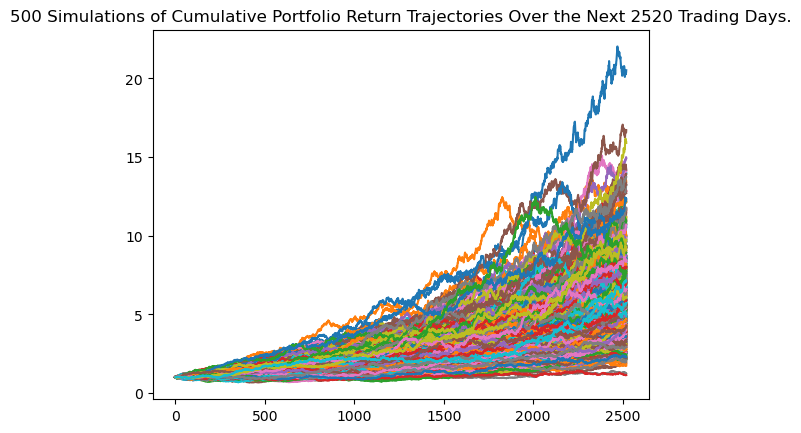

In [148]:
gianforte_MC_sim_line_plot = gianforte_MC_10yr.plot_simulation()

In [153]:
gianforte_MC_summary_stats = gianforte_MC_10yr.summarize_cumulative_return()
print(gianforte_MC_summary_stats)

count           500.000000
mean              5.673019
std               2.711487
min               1.139591
25%               3.810088
50%               5.069035
75%               7.080939
max              20.516776
95% CI Lower      2.208949
95% CI Upper     12.849621
Name: 2520, dtype: float64


In [154]:
ci_lower_10_cumulative_return_gianforte = gianforte_MC_summary_stats[8]*gianforte_investment_capital
ci_upper_10_cumulative_return_gianforte = gianforte_MC_summary_stats[9]*gianforte_investment_capital

# Print the result of your calculations
print(f"there is a 95% chance that over the next 10 years the Gianforte stock portfolio will end with a range between ${ci_lower_30_cumulative_return_gianforte: .2f} and ${ci_upper_30_cumulative_return_gianforte: .2f}")

there is a 95% chance that over the next 10 years the Gianforte stock portfolio will end with a range between $ 3778001794.66 and $ 70308812405.03


In [ ]:
#gianforte_returns=gianforte_close_data.pct_change()
#mean_gianforte_returns=gianforte_returns.mean()
#std_gianforte_returns=gianforte_returns.std()

In [ ]:
#pelosi_stock_info=yf.Tickers(pelosi_tickers)
#pelosi_df=pelosi_stock_info.history(period='5y')
#pelosi_df=pd.DataFrame(pelosi_df)
#pelosi_close_data=pelosi_df['Close']
#pelosi_close_data=pelosi_close_data.reindex(columns= pelosi_tickers)
#display(pelosi_close_data)

In [133]:
print(pelosi_tickers)
pelosi_prices_df = alpaca.get_bars(pelosi_tickers,timeframe,start_date,end_date).df
#warner_stock_info=yf.Tickers(warner_tickers)
#warner_df=warner_stock_info.history(period='5y')
#warner_df=pd.DataFrame(warner_df)
#warner_close_data=warner_df['Close']
#warner_close_data=warner_close_data.reindex(columns=warner_tickers)  
aapl_df = pelosi_prices_df[pelosi_prices_df['symbol']=='AAPL'].drop('symbol',axis=1)
v_df = pelosi_prices_df[pelosi_prices_df['symbol']=='AAPL'].drop('symbol',axis=1)
dis_df = pelosi_prices_df[pelosi_prices_df['symbol']=='AAPL'].drop('symbol',axis=1)
crm_df =pelosi_prices_df[pelosi_prices_df['symbol']=='AAPL'].drop('symbol',axis=1)
meta_df = pelosi_prices_df[pelosi_prices_df['symbol']=='AAPL'].drop('symbol',axis=1)
cmcsa_df = pelosi_prices_df[pelosi_prices_df['symbol']=='AAPL'].drop('symbol',axis=1)
pelosi_prices_df = pd.concat([aapl_df,v_df,dis_df,crm_df,meta_df,cmcsa_df],axis=1,keys=['QQQ', 'SPY', 'VTI', 'FICO', 'WK', 'CRM'])


#warner_returns=warner_close_data.pct_change()
#mean_warner_returns=warner_returns.mean()
#std_warner_returns=warner_returns.std()
pelosi_MC_10yr = MCSimulation(
    portfolio_data = pelosi_prices_df,
    weights = pelosi_weights,
    num_simulation = 500,
    num_trading_days = 252*10
)



class MCSimulation:
    """
    A Python class for runnning Monte Carlo simulation on portfolio price data. 
    
    ...
    
    Attributes
    ----------
    portfolio_data : pandas.DataFrame
        portfolio dataframe
    weights: list(float)
        portfolio investment breakdown
    nSim: int
        number of samples in simulation
    nTrading: int
        number of trading days to simulate
    simulated_return : pandas.DataFrame
        Simulated data from Monte Carlo
    confidence_interval : pandas.Series
        the 95% confidence intervals for simulated final cumulative returns
        
    """
    
    def __init__(self, portfolio_data, weights="", num_simulation=1000, num_trading_days=252):
        """
        Constructs all the necessary attributes for the MCSimulation object.

        Parameters
        ----------
        portfolio_data: pandas.DataFrame
            DataFrame containing stock price information from Alpaca API
        weights: list(float)
            A list fractions representing percentage of total investment per stock. DEFAULT: Equal distribution
        num_simulation: int
            Number of simulation samples. DEFAULT: 1000 simulation samples
        num_trading_days: int
            Number of trading days to simulate. DEFAULT: 252 days (1 year of business days)
        """
        
        # Check to make sure that all attributes are set
        if not isinstance(portfolio_data, pd.DataFrame):
            raise TypeError("portfolio_data must be a Pandas DataFrame")
            
        # Set weights if empty, otherwise make sure sum of weights equals one.
        if weights == "":
            num_stocks = len(portfolio_data.columns.get_level_values(0).unique())
            weights = [1.0/num_stocks for s in range(0,num_stocks)]
        else:
            if round(sum(weights),2) < .99:
                raise AttributeError("Sum of portfolio weights must equal one.")
        
        # Calculate daily return if not within dataframe
        if not "daily_return" in portfolio_data.columns.get_level_values(1).unique():
            close_df = portfolio_data.xs('close',level=1,axis=1).pct_change()
            tickers = portfolio_data.columns.get_level_values(0).unique()
            column_names = [(x,"daily_return") for x in tickers]
            close_df.columns = pd.MultiIndex.from_tuples(column_names)
            portfolio_data = portfolio_data.merge(close_df,left_index=True,right_index=True).reindex(columns=tickers,level=0)    
        
        # Set class attributes
        self.portfolio_data = portfolio_data
        self.weights = weights
        self.nSim = num_simulation
        self.nTrading = num_trading_days
        self.simulated_return = ""
        
    def calc_cumulative_return(self):
        """
        Calculates the cumulative return of a stock over time using a Monte Carlo simulation (Brownian motion with drift).

        """
        
        # Get closing prices of each stock
        last_prices = self.portfolio_data.xs('close',level=1,axis=1)[-1:].values.tolist()[0]
        
        # Calculate the mean and standard deviation of daily returns for each stock
        daily_returns = self.portfolio_data.xs('daily_return',level=1,axis=1)
        mean_returns = daily_returns.mean().tolist()
        std_returns = daily_returns.std().tolist()
        
        # Initialize empty Dataframe to hold simulated prices
        portfolio_cumulative_returns = pd.DataFrame()
        
        # Run the simulation of projecting stock prices 'nSim' number of times
        for n in range(self.nSim):
        
            if n % 10 == 0:
                print(f"Running Monte Carlo simulation number {n}.")
        
            # Create a list of lists to contain the simulated values for each stock
            simvals = [[p] for p in last_prices]
    
            # For each stock in our data:
            for s in range(len(last_prices)):

                # Simulate the returns for each trading day
                for i in range(self.nTrading):
        
                    # Calculate the simulated price using the last price within the list
                    simvals[s].append(simvals[s][-1] * (1 + np.random.normal(mean_returns[s], std_returns[s])))
    
            # Calculate the daily returns of simulated prices
            sim_df = pd.DataFrame(simvals).T.pct_change()
    
            # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
            sim_df = sim_df.dot(self.weights)
    
            # Calculate the normalized, cumulative return series
            portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
        
        # Set attribute to use in plotting
        self.simulated_return = portfolio_cumulative_returns
        
        # Calculate 95% confidence intervals for final cumulative returns
        self.confidence_interval = portfolio_cumulative_returns.iloc[-1, :].quantile(q=[0.025, 0.975])
        
        return portfolio_cumulative_returns
    
    def plot_simulation(self):
        """
        Visualizes the simulated stock trajectories using calc_cumulative_return method.

        """ 
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
            
        # Use Pandas plot function to plot the return data
        plot_title = f"{self.nSim} Simulations of Cumulative Portfolio Return Trajectories Over the Next {self.nTrading} Trading Days."
        return self.simulated_return.plot(legend=None,title=plot_title)
    
    def plot_distribution(self):
        """
        Visualizes the distribution of cumulative returns simulated using calc_cumulative_return method.

        """
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
        
        # Use the `plot` function to create a probability distribution histogram of simulated ending prices
        # with markings for a 95% confidence interval
        plot_title = f"Distribution of Final Cumuluative Returns Across All {self.nSim} Simulations"
        plt = self.simulated_return.iloc[-1, :].plot(kind='hist', bins=10,density=True,title=plot_title)
        plt.axvline(self.confidence_interval.iloc[0], color='r')
        plt.axvline(self.confidence_interval.iloc[1], color='r')
        return plt
    
    def summarize_cumulative_return(self):
        """
        Calculate final summary statistics for Monte Carlo simulated stock data.
        
        """
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
            
        metrics = self.simulated_return.iloc[-1].describe()
        ci_series = self.confidence_interval
        ci_series.index = ["95% CI Lower","95% CI Upper"]
        return metrics.append(ci_series)
    
# Review the simulation input data
pelosi_MC_10yr.portfolio_data.head()

['AAPL', 'V', 'DIS', 'CRM', 'META', 'CMCSA']


QQQ                                      \
                               open    high       low   close    volume   
timestamp                                                                 
2018-05-01 04:00:00+00:00  166.4102  169.20  165.2700  169.10  53569474   
2018-05-02 04:00:00+00:00  175.2250  177.75  173.8000  176.57  66851451   
2018-05-03 04:00:00+00:00  175.8800  177.50  174.4411  176.89  34068446   
2018-05-04 04:00:00+00:00  178.2500  184.25  178.1700  183.83  56204195   
2018-05-07 04:00:00+00:00  185.1800  187.67  184.7500  185.16  42613114   

                                                                     SPY  \
                          trade_count        vwap daily_return      open   
timestamp                                                                  
2018-05-01 04:00:00+00:00      353863  169.130276          NaN  166.4102   
2018-05-02 04:00:00+00:00      437602  176.126868     0.044175  175.2250   
2018-05-03 04:00:00+00:00      246062  176.100682     0.001812  175.8800   
2018-05-04 04:00:00+00:00      370771  182.554203     0.039233  178.2500   
2018-05-07 04:00:00+00:00      267449  186.216900     0.007235  185.1800   

                                   ...          WK                    CRM  \
                             high  ...        vwap daily_return      open   
timestamp                          ...                                      
2018-05-01 04:00:00+00:00  169.20  ...  169.130276          NaN  166.4102   
2018-05-02 04:00:00+00:00  177.75  ...  176.126868     0.044175  175.2250   
2018-05-03 04:00:00+00:00  177.50  ...  176.100682     0.001812  175.8800   
2018-05-04 04:00:00+00:00  184.25  ...  182.554203     0.039233  178.2500   
2018-05-07 04:00:00+00:00  187.67  ...  186.216900     0.007235  185.1800   

                                                                           \
                             high       low   close    volume trade_count   
timestamp                                                                   
2018-05-01 04:00:00+00:00  169.20  165.2700  169.10  53569474      353863   
2018-05-02 04:00:00+00:00  177.75  173.8000  176.57  66851451      437602   
2018-05-03 04:00:00+00:00  177.50  174.4411  176.89  34068446      246062   
2018-05-04 04:00:00+00:00  184.25  178.1700  183.83  56204195      370771   
2018-05-07 04:00:00+00:00  187.67  184.7500  185.16  42613114      267449   

                                                    
                                 vwap daily_return  
timestamp                                           
2018-05-01 04:00:00+00:00  169.130276          NaN  
2018-05-02 04:00:00+00:00  176.126868     0.044175  
2018-05-03 04:00:00+00:00  176.100682     0.001812  
2018-05-04 04:00:00+00:00  182.554203     0.039233  
2018-05-07 04:00:00+00:00  186.216900     0.007235  

[5 rows x 48 columns]

In [128]:
pelosi_MC_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Owner\anaconda3\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:142: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.011519,1.008474,0.991752,1.023923,0.995763,1.012493,1.019762,1.003949,1.018166,1.003382,...,1.018211,0.986920,1.005205,1.003503,1.005811,1.003842,0.996270,0.999375,0.990532,1.004630
2,0.994979,1.022338,1.004137,1.020883,0.982704,1.012133,1.027526,1.002424,1.011140,1.011646,...,1.032094,0.988525,1.003026,1.000847,1.019311,1.000137,1.003289,1.003188,0.998221,0.994156
3,1.000191,1.047361,1.008700,1.010671,0.976239,1.010482,1.012382,1.018710,1.025451,1.005902,...,1.046054,0.987575,0.985922,1.007474,1.039629,0.999912,1.035946,0.979918,0.990092,0.991962
4,1.004950,1.053003,0.998167,1.000939,0.975662,0.997602,1.013049,1.033598,1.045582,1.013812,...,1.046007,0.976740,0.980981,1.009156,1.021295,0.995766,1.060559,0.974462,0.988869,0.982397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,26.546999,14.634083,12.118598,38.922387,19.009577,20.205580,26.802453,12.968485,4.912476,38.885422,...,32.101630,34.908760,9.907382,39.054557,18.310131,24.297366,60.622626,20.573627,26.252536,69.585833
2517,26.727112,14.459968,12.121538,39.259019,19.592113,20.036276,26.569140,13.201037,4.931898,38.898059,...,31.812641,34.721845,9.675167,39.977294,18.063315,24.430238,60.484357,20.701278,25.797333,70.424802
2518,26.730342,14.303410,11.956292,39.016674,19.740773,19.618592,26.664726,13.516531,4.979956,39.044309,...,31.889926,34.946253,9.750113,39.146132,18.043970,24.269762,61.344717,20.393425,26.821016,70.931606
2519,26.896581,14.492318,11.971572,39.785157,19.427367,19.510913,26.228724,13.530131,5.129738,39.315457,...,31.928927,34.592914,9.708346,39.251402,18.104580,24.608785,61.055573,20.735367,26.895919,72.125067


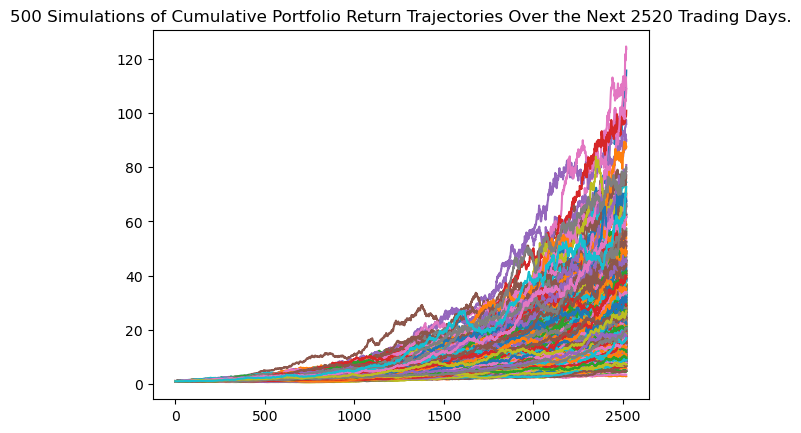

In [129]:
pelosi_MC_sim_line_plot = pelosi_MC_10yr.plot_simulation()

In [139]:
pelosi_MC_summary_stats = pelosi_MC_10yr.summarize_cumulative_return()
pelosi_MC_summary_stats=pd.DataFrame(pelosi_MC_summary_stats)
print(pelosi_MC_summary_stats)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Owner\anaconda3\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

In [132]:
ci_lower_10_cumulative_return_pelosi = pelosi_MC_summary_stats[8]*pelosi_investment_capital
ci_upper_10_cumulative_return_pelosi = pelosi_MC_summary_stats[9]*pelosi_investment_capital

# Print the result of your calculations
print(f"there is a 95% chance that over the next 10 years the stock and bond portion of the portfolio will end with a range between ${ci_lower_10_cumulative_return_pelosi: .2f} and ${ci_upper_10_cumulative_return_pelosi: .2f}")

there is a 95% chance that over the next 10 years the stock and bond portion of the portfolio will end with a range between $ 419698253.53 and $ 4712113176.01


In [ ]:
#pelosi_returns=pelosi_close_data.pct_change()
#mean_pelosi_returns=pelosi_returns.mean()
#std_pelosi_returns=pelosi_returns.std()

In [102]:


spy_shares_warner= 110476
akrex_shares_warner= 762286
trow_shares_warner= 220000
cohox_shares_warner= 1772222
vti_shares_warner= 74359

qqq_shares_gianforte= 149271
spy_shares_gianforte= 82500
vti_shares_gianforte= 235577
fico_shares_gianforte= 39171
wk_shares_gianforte= 181730
crm_shares_gianforte= 25116

aapl_shares_pelosi=548180
visa_shares_pelosi=193939
dis_shares_pelosi=46694
crm_shares_pelosi=37372
meta_shares_pelosi=7442
cmcsa_shares_pelosi=35774

#total shares calculated based on 2018 median share prices for each stock in portfolio b/c most recent portfolio data
#from 2018. should 

In [ ]:
stock_investment= pelosi_investment_capital * 0.02
#spy 2018 median share price =252
#akrex 2018 median share price = 35
#trow 2018 median share price = 116
#cohox 2018 median share price = 14.4
#vti 2018 median share price = 140.4

#qqq 2018 med share price = 164.6
#fico 2018 med share price = 193
#wk 2018 med share price = 26
#rht 2018 med share price = 150.5

#aapl 2018 med share price = 46.7
#visa 2018 med share price = 132
#disney 2018 med share price = 109.65
#crm 2018 med share price = 137
#meta 2018 med share price = 172
#cmcsa 2018 med share price = 35.78

In [ ]:
stock_investment/35.78